In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import networkx as nx
import random
import numpy as np
import misc as ut
import numpy.ma as ma
import copy
from triFastSTMF import triFastSTMF as triFastSTMF
import matplotlib.patches as mpatches

# Create G_1, S, G_2 and compute R and other relations representing our network

In [2]:
m, rank_1, rank_2, n = 45, 10, 15, 30
nodes = m + n + rank_1 + rank_2

In [3]:
G_1 = ma.masked_array(np.random.rand(m, rank_1), mask=np.zeros((m, rank_1))) 
S = ma.masked_array(np.random.rand(rank_1, rank_2), mask=np.zeros((rank_1, rank_2))) 
G_2 = ma.masked_array(np.random.rand(rank_2, n), mask=np.zeros((rank_2, n)))
R = ut.three_max_plus(G_1, S, G_2)

In [4]:
X_Z_relations = R.data # mxn
X_W_relations = ut.max_plus(G_1, S).data # mxrank_2
Y_Z_relations = ut.max_plus(S, G_2).data # rank_1xn

In [5]:
adj = np.zeros((nodes, nodes)) # (m+rank_1+rank_2+n)*(m+rank_1+rank_2+n)

In [6]:
# G_1 represents X_Y relations
adj[:m, m:m+rank_1] = G_1
adj[m:m+rank_1, :m] = G_1.T
# S represents Y_W relations
adj[m:m+rank_1, m+rank_1:m+rank_1+rank_2] = S
adj[m+rank_1:m+rank_1+rank_2, m:m+rank_1] = S.T
# G_2 represents W_Z relations
adj[m+rank_1:m+rank_1+rank_2, m+rank_1+rank_2:nodes] = G_2
adj[m+rank_1+rank_2:nodes, m+rank_1:m+rank_1+rank_2] = G_2.T

In [7]:
adj[:m, m+rank_1+rank_2:nodes] = X_Z_relations
adj[m+rank_1+rank_2:nodes, :m] = X_Z_relations.T

In [8]:
adj

array([[0.        , 0.        , 0.        , ..., 2.71330539, 2.88219543,
        2.82926528],
       [0.        , 0.        , 0.        , ..., 2.70278505, 2.74413508,
        2.81874495],
       [0.        , 0.        , 0.        , ..., 2.7662013 , 2.89596092,
        2.95059191],
       ...,
       [2.71330539, 2.70278505, 2.7662013 , ..., 0.        , 0.        ,
        0.        ],
       [2.88219543, 2.74413508, 2.89596092, ..., 0.        , 0.        ,
        0.        ],
       [2.82926528, 2.81874495, 2.95059191, ..., 0.        , 0.        ,
        0.        ]])

# Network visualization

In [9]:
G = nx.from_numpy_matrix(adj)

In [10]:
list_colors = ["#4169E1"]*45 + ["#E05882"]*10 + ["#A151E0"]*15 + ["#CE8346"]*30

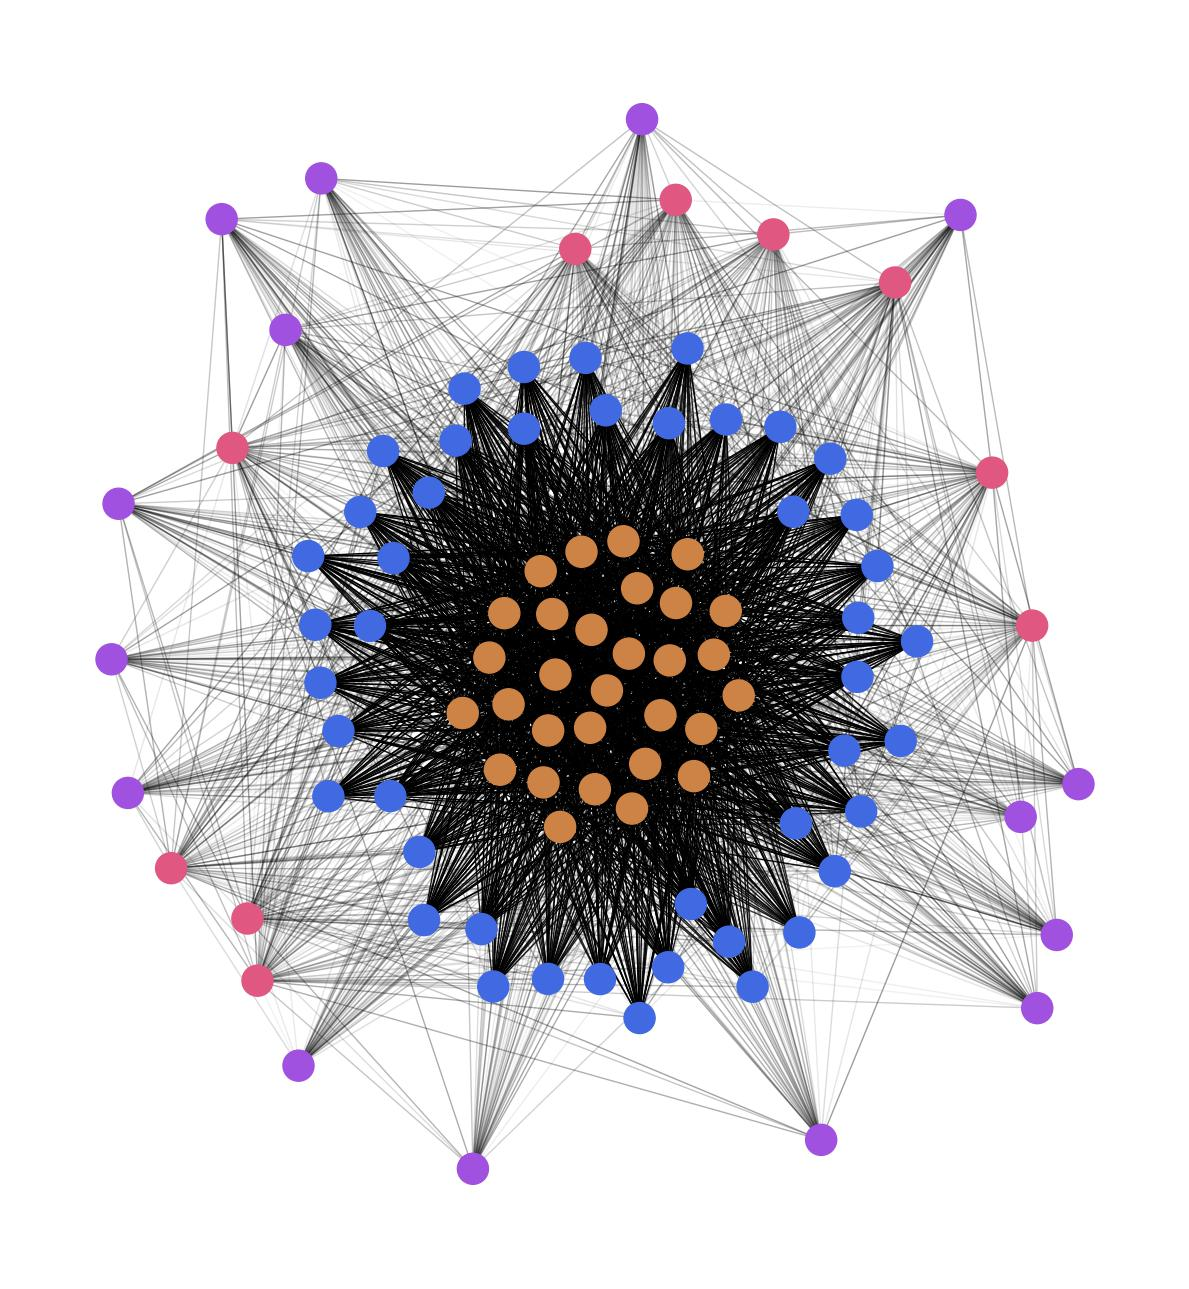

In [11]:
blue_patch = mpatches.Patch(color='#4169E1', label='Partition A')
pink_patch = mpatches.Patch(color='#E05882', label='Partition B')
purple_patch = mpatches.Patch(color='#A151E0', label='Partition C')
orange_patch = mpatches.Patch(color='#CE8346', label='Partition D')

pos = nx.spring_layout(G, seed=123, k=20/np.sqrt(G.order()))
plt.figure(0, figsize=(12,13))
nx.draw_networkx_nodes(G, pos=pos, node_size=500, node_color=list_colors)
alphas = np.array([a["weight"] for u,v,a in G.edges(data=True)])
alphas = alphas/np.max(alphas)
alphas = alphas+0.05
alphas[alphas>1]=1
nx.draw_networkx_edges(G,pos=pos,alpha=alphas)
#for node, (x, y) in pos.items():
    #plt.text(x, y, node, fontsize=11, ha='center', va='center', color="white")
plt.tight_layout()
plt.box(False)
#plt.legend(handles=[blue_patch, pink_patch, purple_patch, orange_patch], prop={"size":14})
plt.savefig("figures/original_synthetic_network.png", dpi=300, bbox_inches="tight")

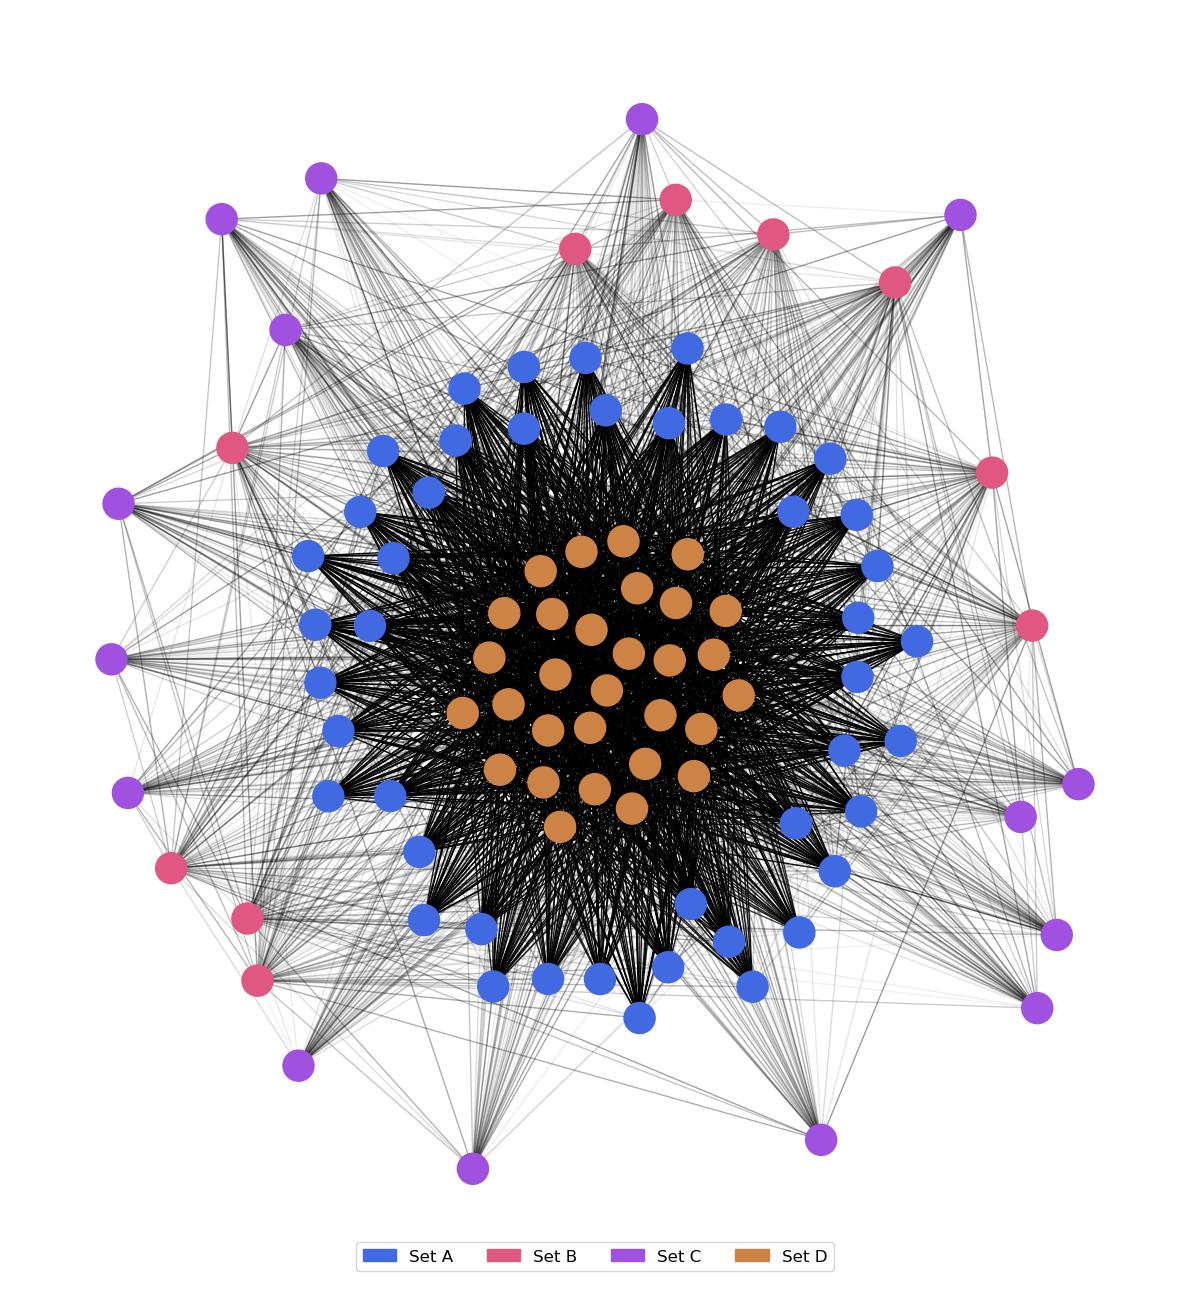

In [12]:
blue_patch = mpatches.Patch(color='#4169E1', label='Set A')
pink_patch = mpatches.Patch(color='#E05882', label='Set B')
purple_patch = mpatches.Patch(color='#A151E0', label='Set C')
orange_patch = mpatches.Patch(color='#CE8346', label='Set D')

pos = nx.spring_layout(G, seed=123, k=20/np.sqrt(G.order()))
plt.figure(0, figsize=(12,13))
nx.draw_networkx_nodes(G, pos=pos, node_size=500, node_color=list_colors)
alphas = np.array([a["weight"] for u,v,a in G.edges(data=True)])
alphas = alphas/np.max(alphas)
alphas = alphas+0.05
alphas[alphas>1]=1
nx.draw_networkx_edges(G,pos=pos,alpha=alphas)
#for node, (x, y) in pos.items():
#    plt.text(x, y, node, fontsize=11, ha='center', va='center', color="white")
plt.tight_layout()
plt.box(False)
plt.legend(handles=[blue_patch, pink_patch, purple_patch, orange_patch], prop={"size":12}, loc="lower center", ncol=4)
plt.savefig("figures/legend.png", dpi=300, bbox_inches="tight")

# We randomly partition all nodes into X, Y, W and Z sets

In [13]:
adj = nx.adjacency_matrix(G) # 100x100

/var/folders/1w/wvs3yw9s1rsg8349s7lnvvj80000gn/T/ipykernel_76138/392668726.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G) # 100x100


In [14]:
print(adj.todense()) # 0 is missing value

[[0.         0.         0.         ... 2.71330539 2.88219543 2.82926528]
 [0.         0.         0.         ... 2.70278505 2.74413508 2.81874495]
 [0.         0.         0.         ... 2.7662013  2.89596092 2.95059191]
 ...
 [2.71330539 2.70278505 2.7662013  ... 0.         0.         0.        ]
 [2.88219543 2.74413508 2.89596092 ... 0.         0.         0.        ]
 [2.82926528 2.81874495 2.95059191 ... 0.         0.         0.        ]]


In [15]:
list_of_indices = np.array(range(0, nodes))
list_of_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

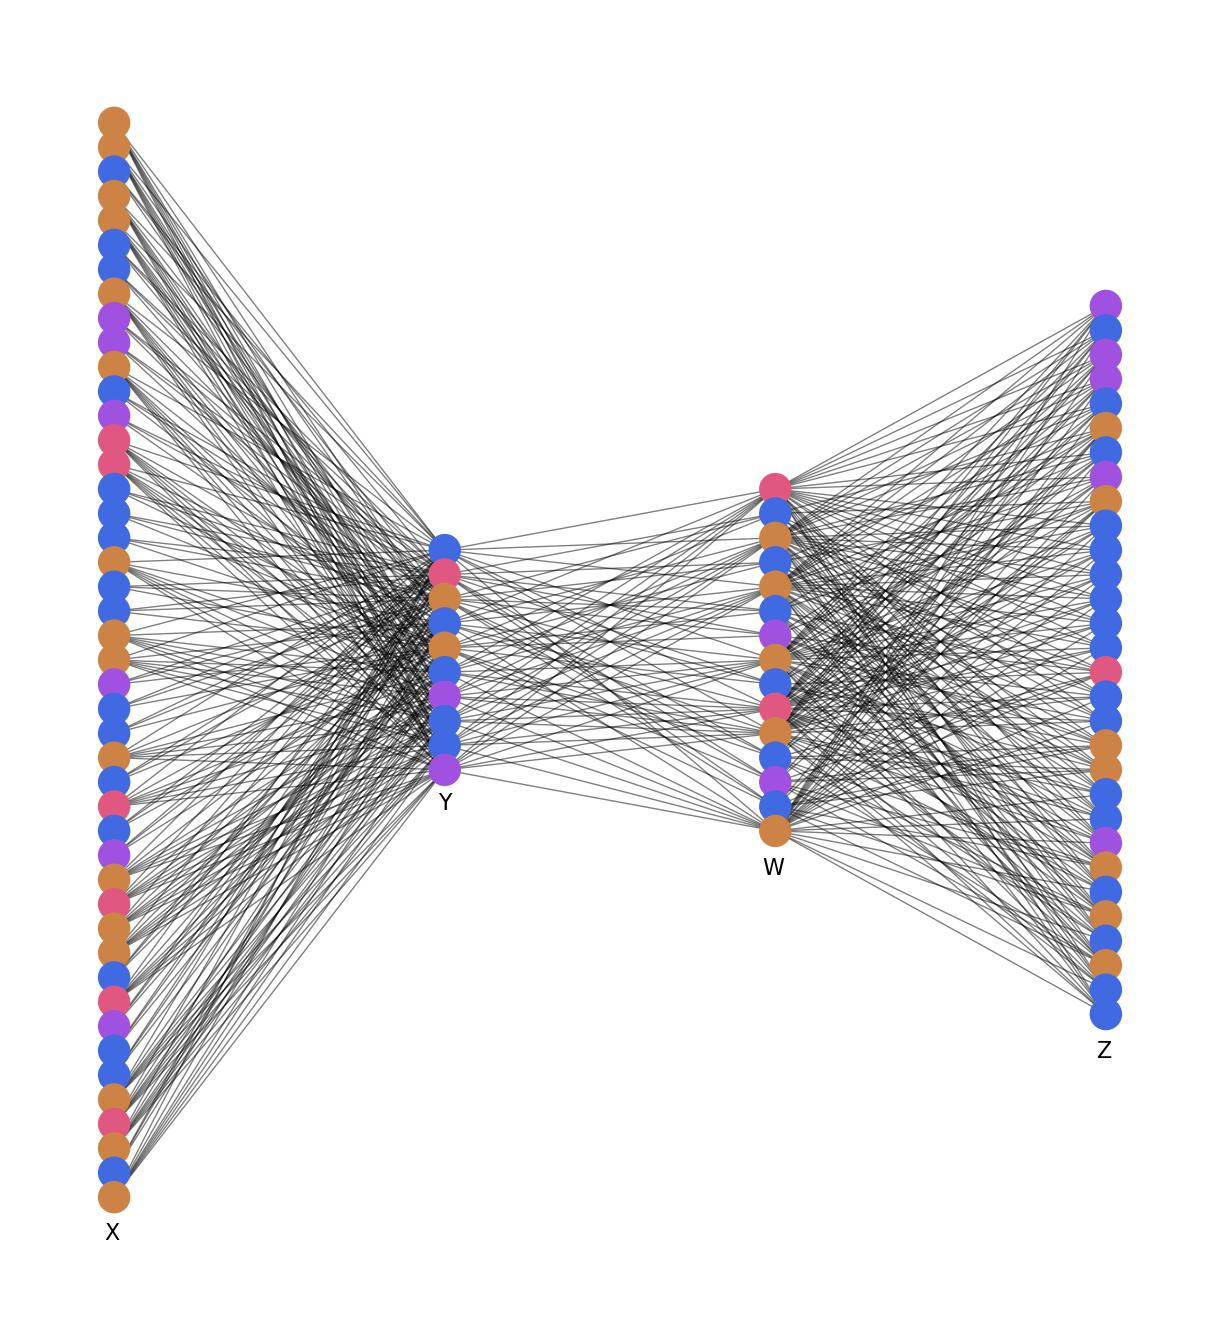

In [16]:
R_1, G_1_first, S_first, G_2_first, js_1, rs_1, ars_1 = ut.random_partitioning(m, rank_1, rank_2, n, adj, list_of_indices, 1, True)

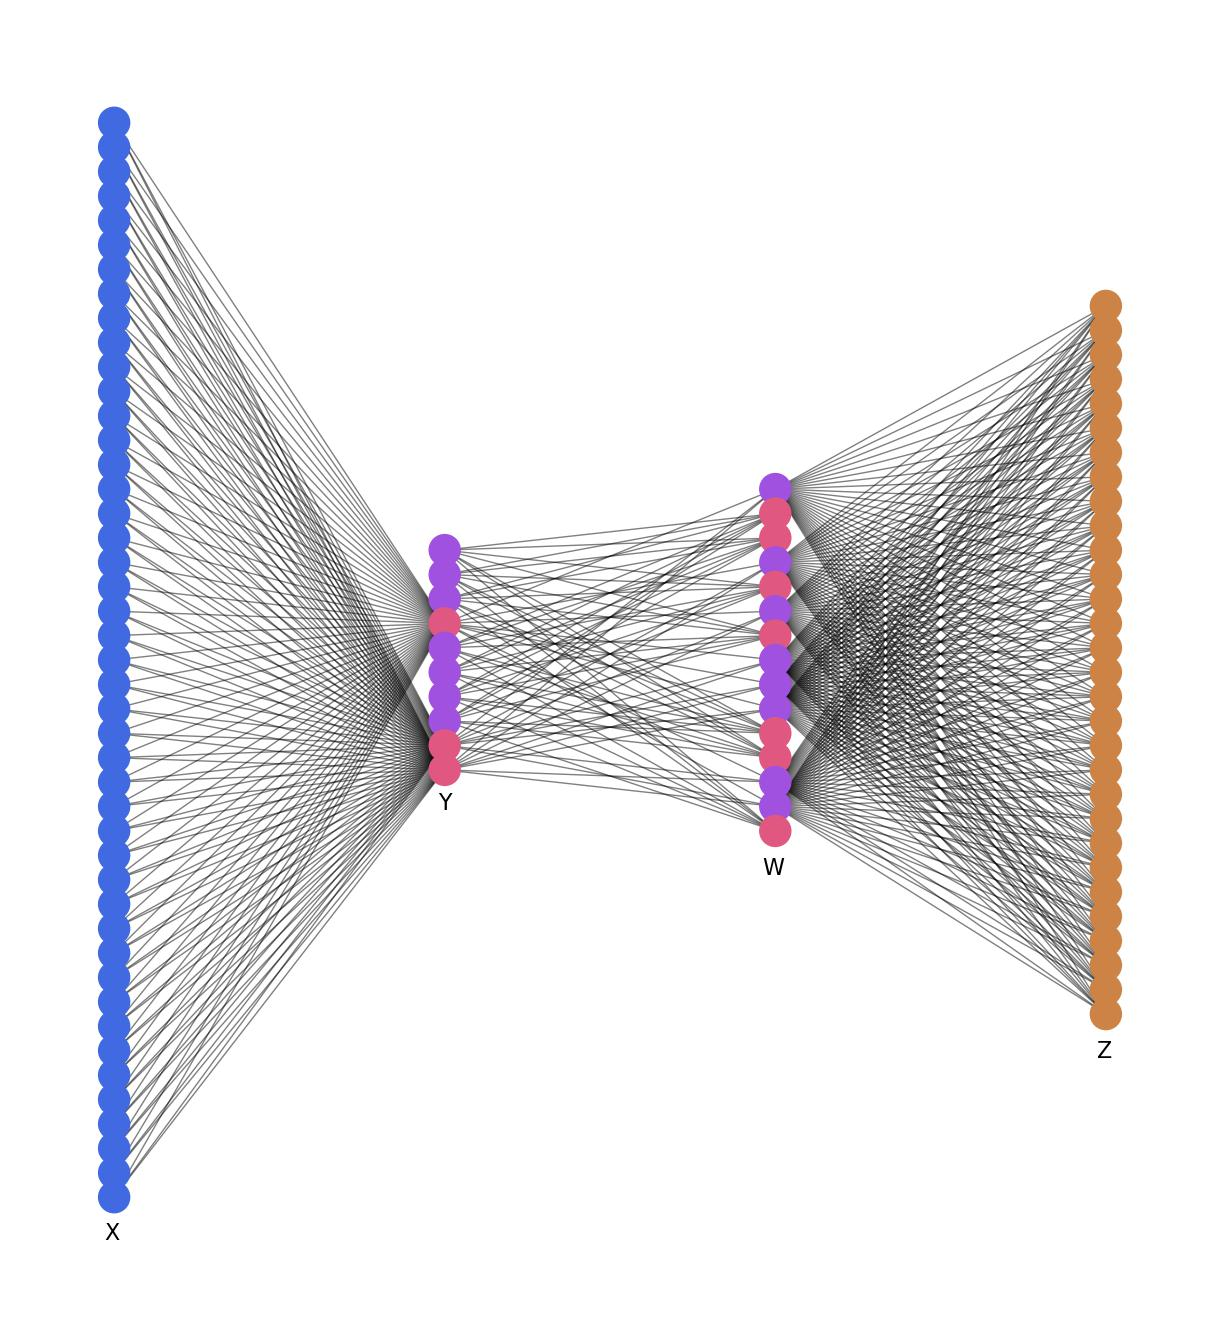

In [17]:
R_1, G_1_first, S_first, G_2_first, js_1, rs_1, ars_1 = ut.pseudorandom_partitioning(m, rank_1, rank_2, n, adj, list_of_indices, 1, True)

## Fitting

In [18]:
init_stmf="fixed"
threshold=100#100
jaccard_scores_pseudo, rs_pseudo, ars_pseudo, approx_errors_pseudo = [], [], [], []
jaccard_scores_random, rs_random, ars_random, approx_errors_random = [], [], [], []
repeat = 25#25

In [19]:
for i in range(repeat):
    print(i)
    R, G_1, S, G_2, js, rs, ars = ut.random_partitioning(m, rank_1, rank_2, n, adj, list_of_indices, i)
    R_ps, G_1_ps, S_ps, G_2_ps, js_ps, rs_ps, ars_ps = ut.pseudorandom_partitioning(m, rank_1, rank_2, n, adj, list_of_indices, i)
    # first run
    model = triFastSTMF(rank_1 = rank_1, rank_2 = rank_2, initialization=init_stmf, threshold=threshold, fixed_U=G_1, fixed_X=S, fixed_V=G_2)
    model.fit(R)
    error = model.errors[-1]
    jaccard_scores_random.append(js)
    rs_random.append(rs)
    ars_random.append(ars)
    approx_errors_random.append(error)
    # second run
    model = triFastSTMF(rank_1 = rank_1, rank_2 = rank_2, initialization=init_stmf, threshold=threshold, fixed_U=G_1_ps, fixed_X=S_ps, fixed_V=G_2_ps)
    model.fit(R_ps)
    error = model.errors[-1]
    jaccard_scores_pseudo.append(js_ps)
    rs_pseudo.append(rs_ps)
    ars_pseudo.append(ars_ps)
    approx_errors_pseudo.append(error)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [40]:
# plt.scatter(jaccard_scores_pseudo, approx_errors_pseudo, label="partially-random partitions", s=12)
# plt.scatter(jaccard_scores_random, approx_errors_random, label="random partitions", s=12)
# plt.xlabel("jaccard score")
# plt.ylabel("approximation error")
# plt.yticks([50, 100, 150, 200])#, 350, 450])
# plt.ylim(40, 220)
# plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
# plt.xlim(0, 1.1)
# plt.legend()
# plt.savefig("figures/jaccard_score_vs_approx_error.png")

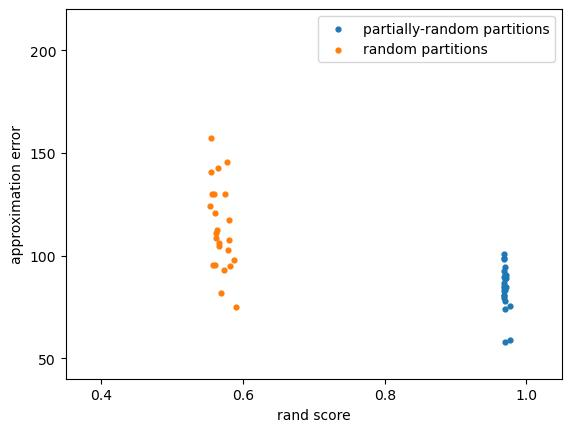

In [37]:
plt.scatter(rs_pseudo, approx_errors_pseudo, label="partially-random partitions", s=12)
plt.scatter(rs_random, approx_errors_random, label="random partitions", s=12)
plt.xlabel("rand score")
plt.ylabel("approximation error")
plt.yticks([50, 100, 150, 200])#, 350, 450])
plt.ylim(40, 220)
plt.xticks([0.4, 0.6, 0.8, 1])
plt.xlim(0.35, 1.05)
plt.legend()
plt.savefig("figures/rand_score_vs_approx_error.png")

In [41]:
# plt.scatter(ars_pseudo, approx_errors_pseudo, label="partially-random partitions", s=12)
# plt.scatter(ars_random, approx_errors_random, label="random partitions", s=12)
# plt.xlabel("adjusted rand score")
# plt.ylabel("approximation error")
# plt.yticks([50, 100, 150, 200])#, 350, 450])
# plt.ylim(40, 220)
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# plt.xlim(-0.05, 1.1)
# plt.legend()
# plt.savefig("figures/adjusted_rand_score_vs_approx_error.png")

In [42]:
# random
#np.savetxt('data/jaccard_scores_random.csv', np.array(jaccard_scores_random), delimiter=',')
np.savetxt('data/rs_random.csv', np.array(rs_random), delimiter=',')
#np.savetxt('data/ars_random.csv', np.array(ars_random), delimiter=',')
np.savetxt('data/approx_errors_random.csv', np.array(approx_errors_random), delimiter=',')
# partially-random
#np.savetxt('data/jaccard_scores_pseudo.csv', np.array(jaccard_scores_pseudo), delimiter=',')
np.savetxt('data/rs_pseudo.csv', np.array(rs_pseudo), delimiter=',')
#np.savetxt('data/ars_pseudo.csv', np.array(ars_pseudo), delimiter=',')
np.savetxt('data/approx_errors_pseudo.csv', np.array(approx_errors_pseudo), delimiter=',')